# Reporte de calidad
En este documento se encuentra un reporte preliminar de la calidad de los datos. Inicialmente, los datos que posiblemente vamos a utilizar son datos de sismos de [USGS](https://earthquake.usgs.gov) para Estados Unidos, de [IRIS](https://www.iris.edu/hq/) para Japón y de [SSN](http://www.ssn.unam.mx) para México.

In [1]:
# Importamos las librerias
import requests                     # hacer request a la pagina
import pandas as pd                 # dataframes
import matplotlib.pyplot as plt     # plots
import seaborn as sns               # plots
import numpy as np                  # manejo de arrays
import datetime                     # formato de fechas
from math import ceil               # redondeo

# Graficar en mapa con latitud y longitud
import geopandas as gpd                     
from geopandas import GeoDataFrame
from shapely.geometry import Point
import matplotlib.colors as colors


sns.set_style("darkgrid")

## Estados Unidos
El Servicio Geológico de Estados Unidos (USGS, por sus siglas en inglés) es una agencia científica del gobierno de los Estados Unidos. Posee un catálogo de datos de eventos sísmicos de [distintos catálogos](https://earthquake.usgs.gov/data/comcat/#avail). Los datos se obtienen a partir de queries que se pueden formular en https://earthquake.usgs.gov/earthquakes/search/. Los queries tienen un límite de 20K filas por query, por lo que nos limitaremos a los datos de los últimos 3 meses, sin acotar el rango de magnitud de los sismos. Vamos a analizar la información de Estados Unidos.

In [2]:
# url de https://earthquake.usgs.gov/earthquakes/search/
url_usa_con = 'https://earthquake.usgs.gov/fdsnws/event/1/query.geojson?starttime=2022-08-17%2000:00:00&endtime=2022-11-16%2023:59:59&maxlatitude=50&minlatitude=24.6&maxlongitude=-65&minlongitude=-125&minmagnitude=0&orderby=time-asc'
url_alaska = 'https://earthquake.usgs.gov/fdsnws/event/1/query.geojson?starttime=2022-08-17%2000:00:00&endtime=2022-11-16%2023:59:59&maxlatitude=71.511&minlatitude=53.409&maxlongitude=-141.029&minlongitude=-168.1&minmagnitude=0&orderby=time-asc'

In [3]:
def read_usgs(url):
    '''Lectura de queries de USGS https://earthquake.usgs.gov/earthquakes/search/'''
    # Hacemos un request porque hay json anidados
    data_json = requests.get(url).json()
    # el diccionario de features es el que tiene la infomación
    df = pd.json_normalize(data_json, record_path =['features'])

    return df

In [4]:
# USA
# Se divide porque tambien hay que tomaren cuenta alaska
df_usa_con = read_usgs(url_usa_con)
df_alaska = read_usgs(url_alaska)
df_usa = pd.concat([df_usa_con, df_alaska])

# Cambiamos el nombre de las columna
# Quitamos properties de los nombres de columnas
lista_new = [palabra.replace('properties.', '') for palabra in df_usa.columns.to_list()]
new_names = dict(zip(df_usa.columns.to_list(), lista_new))
# Cambiamos los nombres
df_usa.rename(new_names, axis='columns', inplace=True)

print('El total de sismos en 3 meses en USA es: ', df_usa.shape[0])

El total de sismos en 3 meses en USA es:  25479


Los conjuntos de datos poseen 30 columnas. La descripción del contenido de cada columna se encuentra en https://earthquake.usgs.gov/data/comcat/data-eventterms.php.

A continuación vemos que el porcentaje de faltantes por columna es alto para las variables `tz`, `felt`, `cdi`, `mmi` y `alert`.

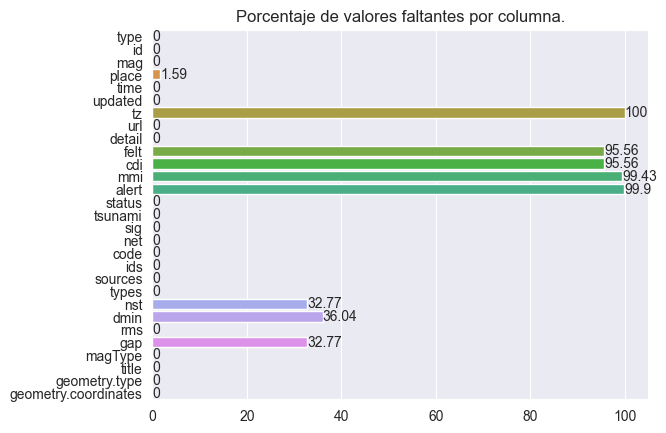

In [5]:
# Ploteamos el numero de faltantes por columna
ax = sns.barplot(x = (round(df_usa.isnull().sum()*100/df_usa.shape[0],2)).values, y = df_usa.columns)
ax.bar_label(ax.containers[0])
plt.title('Porcentaje de valores faltantes por columna.');

Para poder analizar más allá, hay que formatear los datos. Sin embargo, eliminaremos las columnas que tengan más de 50% de faltantes y columnas con un solo valor único. Además se eliminaron las columnas `detail`, `ids`, `sources` y `type`, ya que de acuerdo a su descripción consideramos que no aportan información relacionada al objetivo del proyecto.

In [6]:
df_nulls = df_usa.isnull().sum()*100/df_usa.shape[0]
print('Porcentaje de faltantes')
df_nulls[df_nulls > 50]

Porcentaje de faltantes


tz       100.000000
felt      95.564975
cdi       95.564975
mmi       99.426979
alert     99.901880
dtype: float64

In [7]:
df_uniques = df_usa[df_usa.columns[~df_usa.columns.isin(['geometry.coordinates'])]].nunique()
print('Cantidad de unicos')
df_uniques[df_uniques == 1]

Cantidad de unicos


type             1
alert            1
type             1
geometry.type    1
dtype: int64

Las columnas se formatearon en el EDA. Se hizo un formateo básico: limpiar strings y cambiar el tipo de dato a float, str o int. Además, se agregó "No Data" a los valores faltantes en place:

In [8]:
df_usa = pd.read_csv('../datasets/usgs-reporte.csv')
df_usa = df_usa[df_usa.country == 'USA']
df_usa.drop('country', axis='columns', inplace=True)

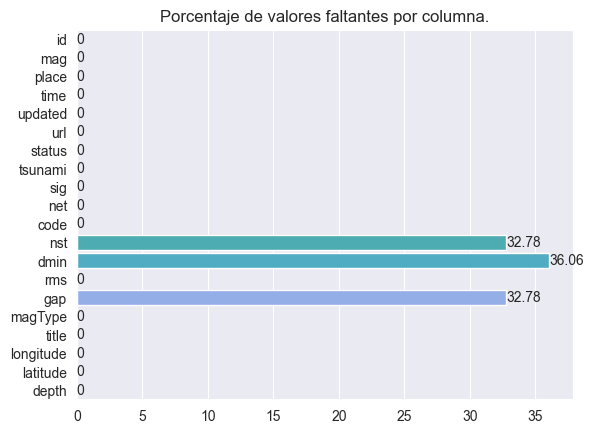

In [9]:
# Faltantes por columna
ax = sns.barplot(x = (round(df_usa.isnull().sum()*100/df_usa.shape[0],2)).values, y = df_usa.columns)
ax.bar_label(ax.containers[0])
plt.title('Porcentaje de valores faltantes por columna.');

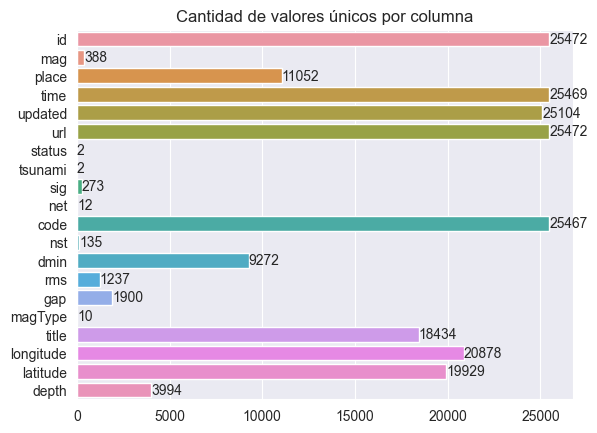

In [10]:
# Valores únicos
ax = sns.barplot(x = df_usa.nunique().values, y = df_usa.columns)
ax.bar_label(ax.containers[0])
plt.title('Cantidad de valores únicos por columna');

Observamos algunos gráficos: correlación de las variables numéricas y escala de los sismos de acuerdo a su ubicación geográfica.

En las variables numéricas vemos que existe una correlación entre las variables `sig` y `mag`, lo que quiere decir que a mayor magnitud, más significativo es el sismo.

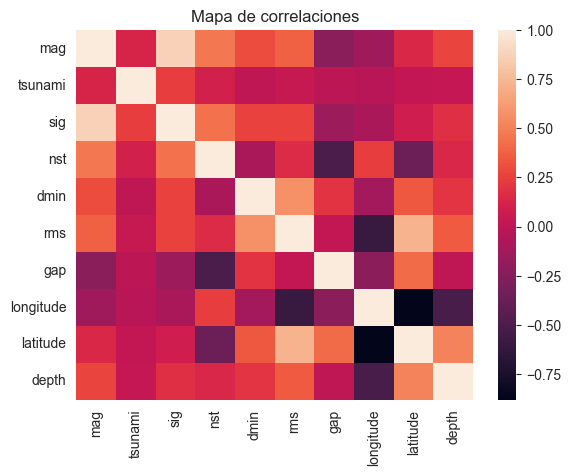

In [11]:
sns.heatmap(df_usa.corr(numeric_only=True))
plt.title('Mapa de correlaciones');

En el mapa, notamos que en Estados Unidos hay muchos registros de sismos de pequeña escala, mientras que en Japón y México hay registros de sismos de escalas mayores a 3.

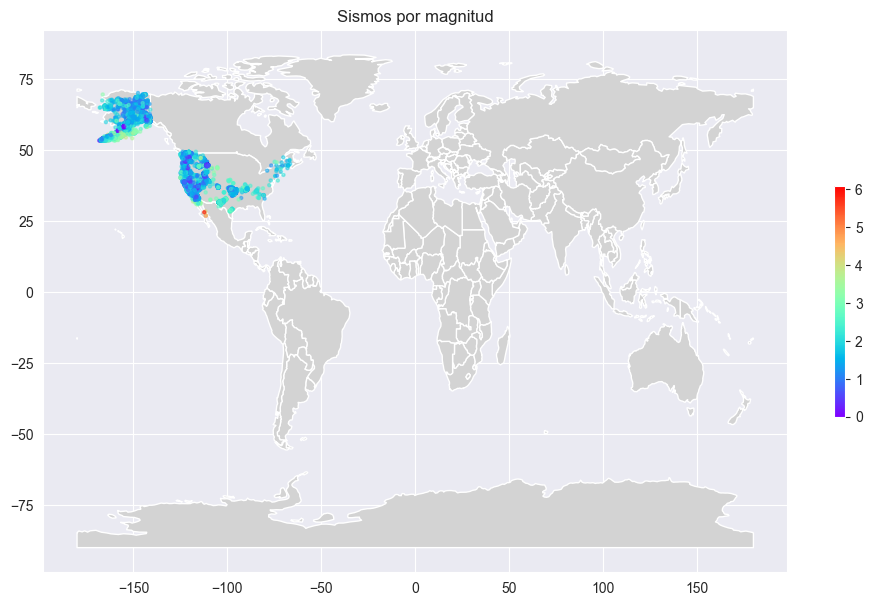

In [12]:
# https://towardsdatascience.com/plotting-maps-with-geopandas-428c97295a73
# Escogemos el mapa
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# Creamos el objeto geodataframe
crs = 'EPSG:4326'
geometry = [Point(xy) for xy in zip(df_usa['longitude'], df_usa['latitude'])]
geo_df = gpd.GeoDataFrame(df_usa, 
                          crs = crs, 
                          geometry = geometry)

# por magnitud
fig, ax = plt.subplots(figsize = (12,10))

world.to_crs(epsg=4326).plot(ax=ax, color='lightgrey')

geo_df.plot(column = 'mag', ax=ax, cmap = 'rainbow',
            legend = True, legend_kwds={'shrink': 0.3}, 
            markersize = 5, alpha=0.5)
            
ax.set_title('Sismos por magnitud');

Por último, la mayor parte de los datos fue revisado por humanos, lo que da veracidad en la información

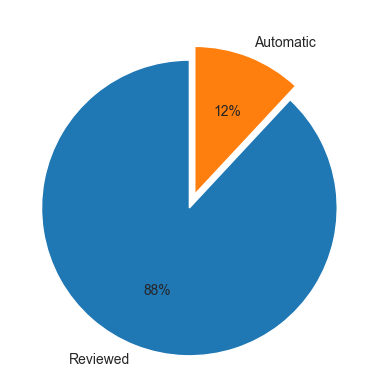

In [13]:
df_per = df_usa.status.value_counts()/df_usa.shape[0]*100
explode = (0.1, 0)
plt.pie(df_per.values, labels = df_per.index.to_list(), autopct='%.0f%%', startangle=90, explode=explode)

plt.show()

## Japón
Para obtener datos de sismos en Japón vamos a utilizar los datos del catálogo de IRIS. IRIS (Incorporated Research Institutions for Seismology) es un consorcio universitario de investigación dedicado a explorar el interior de la Tierra a través de la recopilación y distribución de datos sismográficos. También analizaremos un periodo de 3 meses.

In [14]:
# leemos los datos
url = "https://service.iris.edu/fdsnws/event/1/query?starttime=2022-08-17T00:00:00&endtime=2022-11-16T23:59:59&orderby=time&format=geocsv&maxlat=47.587&minlon=128.288&maxlon=157.029&minlat=30.234&nodata=404"
df_jp = pd.read_csv(url, sep='|', skiprows=4)
df_jp = df_jp[df_jp.EventLocationName.str.contains('JAPAN')]
df_jp.head()

,EventID,Time,Latitude,Longitude,Depth,Author,Catalog,Contributor,ContributorID,MagType,Magnitude,MagAuthor,EventLocationName
1,11620696,2022-11-14T13:27:58Z,37.4234,137.2428,11.551,us,NEIC PDE,us,us7000iplv,mb,4.6,us,"NEAR WEST COAST OF HONSHU, JAPAN"
2,11620652,2022-11-14T08:08:26Z,33.8016,137.2543,357.441,"us,usauto,pt",NEIC PDE,us,us7000ipkm,mww,6.1,us,"NEAR S. COAST OF HONSHU, JAPAN"
7,11619262,2022-11-10T01:22:46Z,35.6033,141.8773,10.000,us,NEIC PDE,us,us7000inpa,mb,4.6,us,"NEAR EAST COAST OF HONSHU, JAPAN"
8,11618969,2022-11-09T08:40:12Z,36.1738,140.0330,56.045,us,NEIC PDE,us,us7000ingc,mb,5.0,us,"NEAR EAST COAST OF HONSHU, JAPAN"
9,11618888,2022-11-09T03:37:25Z,31.6502,131.8419,35.000,us,NEIC PDE,us,us7000inf2,mb,4.5,us,"KYUSHU, JAPAN"


A continuación, la descripción de cada columna:
```
    EventID: Identificador del evento.
    Time: Fecha y hora del evento.
    Latitude: Latitud del epicentro del sismo.
    Longitude: Longitud del epicentro del sismo.
    Depth: Profundidad del epicentro del sismo.
    Author:
    Catalog: Catálogo al que pertenece el evento.
    Contributor: Nombre del grupo que contribuye al evento.
    ContributorID: Identificador del contribuidor.
    MagTyoe: Método de cálculo preferido de la magnitud del evento.
    Magnitude: Magnitud del evento.
    MagAuthor:
    EventLocationName: Lugar del evento.
    Country: País donde ocurrió el evento.
```
En este conjunto de datos no hay valores faltantes.

Vemos que el total de sismos registrados para japón es mucho menor que los registrados para Estados Unidos. Sin embargo, esto se debe a que no se registran sismos de escalas pequeñas.

In [15]:
print('El total de sismos en 3 meses en Japón es: ', df_jp.shape[0])
print('La menor magnitud registrada es: ', df_jp.Magnitude.min())

El total de sismos en 3 meses en Japón es:  162
La menor magnitud registrada es:  4.0


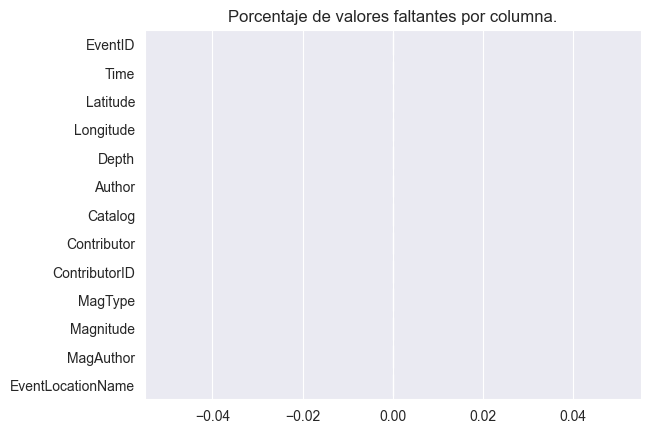

In [16]:
# Ploteamos el numero de faltantes por columna
sns.barplot(x = (df_jp.isnull().sum()*100/df_jp.shape[0]).values, y = df_jp.columns)
plt.title('Porcentaje de valores faltantes por columna.');

Se hicieron trasformaciones basicas de tipo de dato y formateo de strings

In [17]:
df_jp = pd.read_csv('../datasets/iris-reporte.csv')
df_jp.drop('Unnamed: 0', axis='columns', inplace=True)

De los valores únicos, vemos que `Catalog` y `MagAuthor` tienen un solo valor, por lo que podrían descartarse.

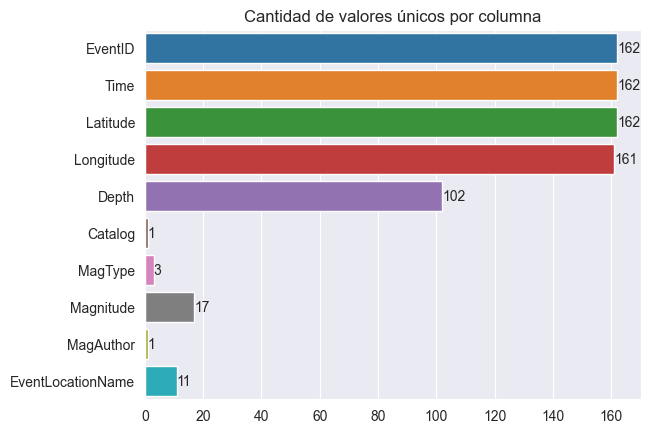

In [18]:
# Valores únicos
ax = sns.barplot(x = df_jp.nunique().values, y = df_jp.columns)
ax.bar_label(ax.containers[0])
plt.title('Cantidad de valores únicos por columna');

Observamos algunos gráficos: correlación de las variables numéricas y escala de los sismos de acuerdo a su ubicación geográfica.

En las variables numéricas vemos que no existe correlaciones sobre o debajo 0.5, por lo que podemos decir que las variables no están correlacionadas.

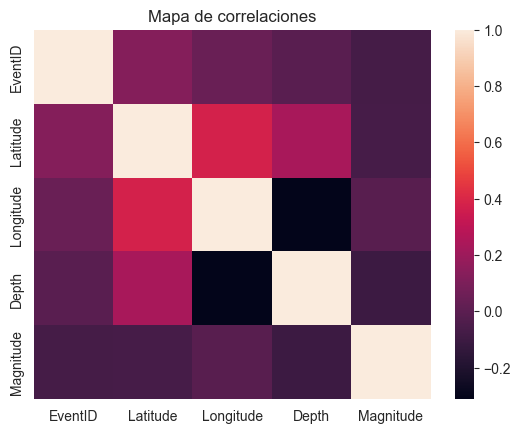

In [19]:
sns.heatmap(df_jp.corr(numeric_only=True))
plt.title('Mapa de correlaciones');

En el mapa vemos claramente que no se registran sismos de magnitudes menores a 4.

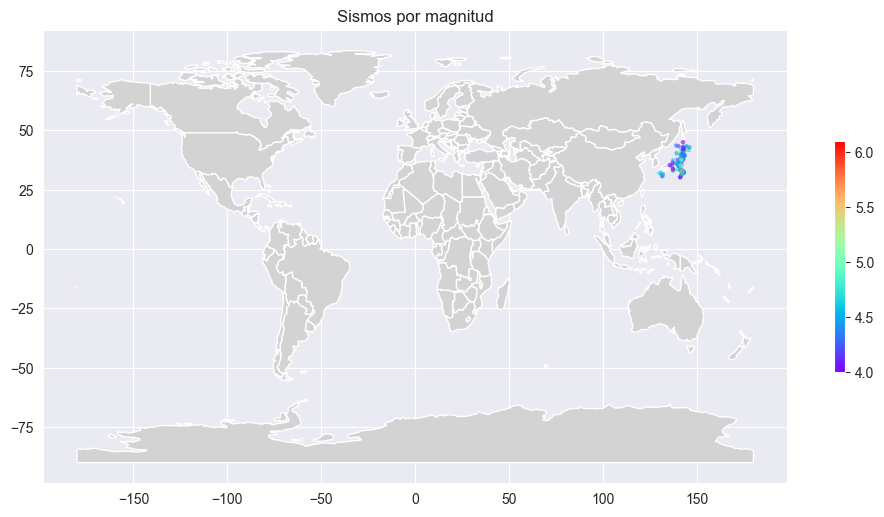

In [20]:
# https://towardsdatascience.com/plotting-maps-with-geopandas-428c97295a73
# Escogemos el mapa
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# Creamos el objeto geodataframe
crs = 'EPSG:4326'
geometry = [Point(xy) for xy in zip(df_jp['Longitude'], df_jp['Latitude'])]
geo_df = gpd.GeoDataFrame(df_jp, 
                          crs = crs, 
                          geometry = geometry)

# por magnitud
fig, ax = plt.subplots(figsize = (12,10))

world.to_crs(epsg=4326).plot(ax=ax, color='lightgrey')

geo_df.plot(column = 'Magnitude', ax=ax, cmap = 'rainbow',
            legend = True, legend_kwds={'shrink': 0.3}, 
            markersize = 5, alpha=0.5)
            
ax.set_title('Sismos por magnitud');

## México
Los datos de eventos sísmicos en México se pueden obtener a través de el [Servicio Sismológico Nacional (SSN)](http://www.ssn.unam.mx) de México. Nuevamente, analizaremos los datos de un periodo de 3 meses, obtenidos de http://www2.ssn.unam.mx:8080/catalogo/#.

In [21]:
df_mx = pd.read_csv('../datasets/SSNMX_catalogo_20220817_20221116_utc.csv', skiprows=4, skipfooter=7, engine='python')
df_mx.head()

,Fecha UTC,Hora UTC,Magnitud,Latitud,Longitud,Profundidad,Referencia de localizacion,Fecha local,Hora local,Estatus
0,2022-08-17,00:47:09,4.0,17.14,-101.84,9.0,"64 km al SUROESTE de ZIHUATANEJO, GRO",2022-08-16,19:47:09,verificado
1,2022-08-17,01:20:35,4.1,14.75,-92.99,123.0,"71 km al SUROESTE de HUIXTLA, CHIS",2022-08-16,20:20:35,verificado
2,2022-08-17,01:27:40,3.6,18.16,-103.45,5.0,"75 km al SUROESTE de COALCOMAN, MICH",2022-08-16,20:27:40,verificado
3,2022-08-17,01:34:14,3.9,16.76,-95.01,5.0,"13 km al SUR de MATIAS ROMERO, OAX",2022-08-16,20:34:14,verificado
4,2022-08-17,01:49:39,3.6,17.14,-100.41,37.0,"8 km al SURESTE de ATOYAC DE ALVAREZ, GRO",2022-08-16,20:49:39,verificado


In [22]:
df_mx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7863 entries, 0 to 7862
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Fecha UTC                   7863 non-null   object 
 1   Hora UTC                    7863 non-null   object 
 2   Magnitud                    7863 non-null   float64
 3   Latitud                     7863 non-null   float64
 4   Longitud                    7863 non-null   float64
 5   Profundidad                 7863 non-null   float64
 6   Referencia de localizacion  7863 non-null   object 
 7   Fecha local                 7863 non-null   object 
 8   Hora local                  7863 non-null   object 
 9   Estatus                     7863 non-null   object 
dtypes: float64(4), object(6)
memory usage: 614.4+ KB


A continuación, la descripción de cada columna:
```
    Fecha UTC: Fecha en formato UTC.
    Hora UTC: Hora en formato UTC.
    Magnitud: Magnitud del sismo en el epicentro.
    Latitud: Latitud geográfica del epicentro del sismo.
    Longitud: Longitud geográfica del epicentro del sismo.
    Profundidad: Profundidad en Km del epicentro del sismo.
    Referencia de Localización: Referencia del lugar del epicentro del sismo.
    Fecha Local: Fecha local del sismo.
    Hora Local: Hora local del sismo.
    Estatus: Si el evento fue verificado por una persona     
```
En este conjunto de datos no hay valores faltantes. Y el total de sismos es mayor al de Japón, ya que se registran sismos des pequeñas magnitudes.

In [23]:
print('El total de sismos en 3 meses en México es: ', df_mx.shape[0])
print('La menor magnitud registrada es: ', df_mx.Magnitud.min())

El total de sismos en 3 meses en México es:  7863
La menor magnitud registrada es:  1.0


La columna de `Estatus` posee un único valor que indica que los datos fueron revisados por una persona, pero no se descarta porque esto da información sobre la veracidad de los datos y los datos nuevos podrían tener otro valor.

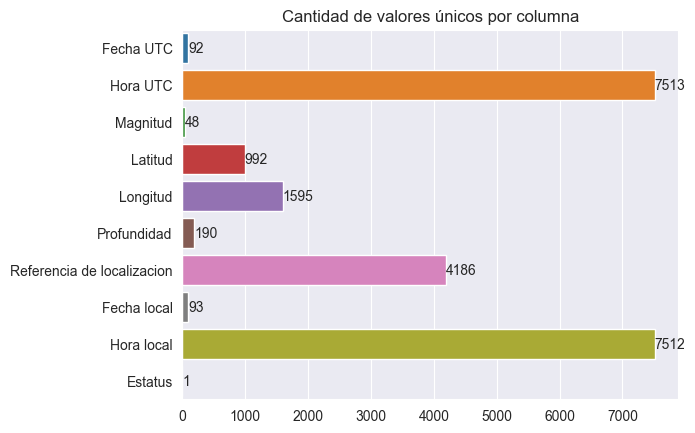

In [24]:
# Valores únicos
ax = sns.barplot(x = df_mx.nunique().values, y = df_mx.columns)
ax.bar_label(ax.containers[0])
plt.title('Cantidad de valores únicos por columna');

Observamos algunos gráficos: correlación de las variables numéricas y escala de los sismos de acuerdo a su ubicación geográfica.

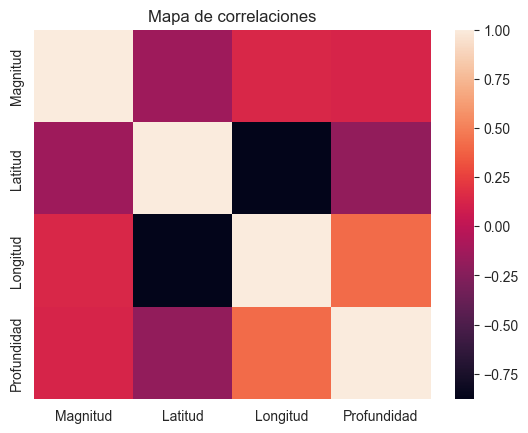

In [25]:
sns.heatmap(df_mx.corr(numeric_only=True))
plt.title('Mapa de correlaciones');

En el mapa vemos que la mayoría de los sismos tienen una magnitud entre 3 y 5.

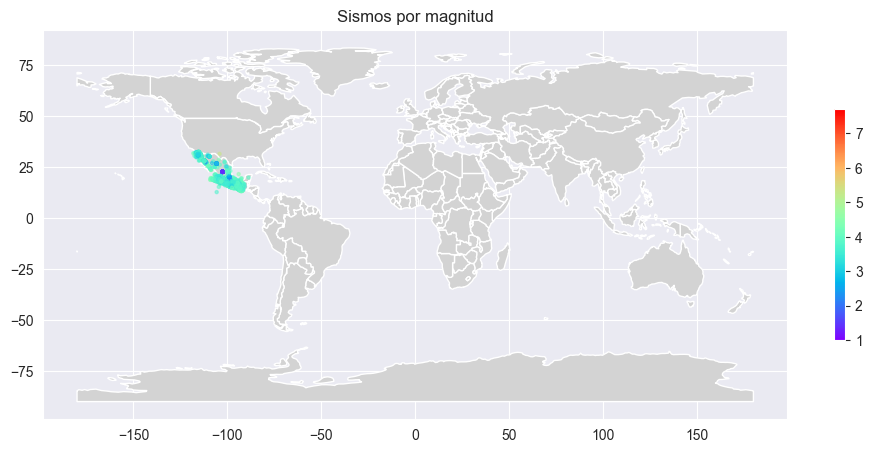

In [27]:
# https://towardsdatascience.com/plotting-maps-with-geopandas-428c97295a73
# Escogemos el mapa
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# Creamos el objeto geodataframe
crs = 'EPSG:4326'
geometry = [Point(xy) for xy in zip(df_mx['Longitud'], df_mx['Latitud'])]
geo_df = gpd.GeoDataFrame(df_mx, 
                          crs = crs, 
                          geometry = geometry)

# por magnitud
fig, ax = plt.subplots(figsize = (12,10))

world.to_crs(epsg=4326).plot(ax=ax, color='lightgrey')

geo_df.plot(column = 'Magnitud', ax=ax, cmap = 'rainbow',
            legend = True, legend_kwds={'shrink': 0.3}, 
            markersize = 5, alpha=0.5)
            
ax.set_title('Sismos por magnitud');